In [22]:
import sys
import os
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.preprocess_data import preprocess_data, split_and_format_data
from src.train_test import get_dataloaders, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# STOCK_PATH = "../data/apple_stock/AAPL_1980-12-03_2025-03-15.csv"
STOCK_PATHS = [
    "../data/faang_stocks/facebook.csv",
    "../data/faang_stocks/amazon.csv",
    "../data/faang_stocks/apple.csv",
    "../data/faang_stocks/google.csv",
    "../data/faang_stocks/netflix.csv"
]
SENTIMENT_PATH = "../data/financial_tweets/financial_tweets_sentiments.csv"

WINDOW_SIZE = 5

In [ ]:
dfs = []

for stock_path in STOCK_PATHS:
    if "netflix" in stock_path or "facebook" in stock_path:
        date_col = "Date"
        price_col = "Close"
    else:
        date_col = "date"
        price_col = "close"

    df = preprocess_data(stock_path, SENTIMENT_PATH, stocks_date_col=date_col, stocks_price_col=price_col)
    dfs.append(df)

X_train, y_train, X_val, y_val, X_test, y_test, mean, std = split_and_format_data(df, window_size=WINDOW_SIZE, split1=0.7, split2=0.9)
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=16)

### No sentiment

[ Epoch 4900 / 5000 ] Train loss = 0.030679109011543915 Val loss = 0.403329915056626 Best val loss = 0.403329915056626


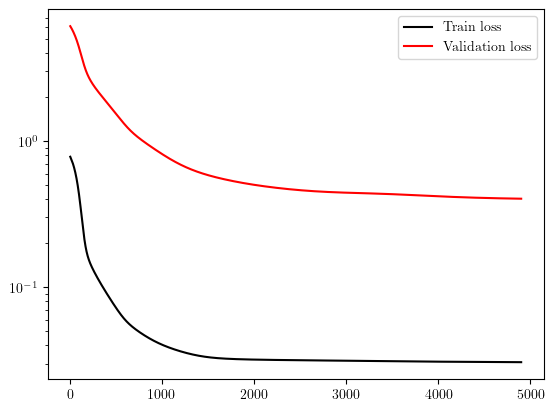

Best val loss: 0.40251228710015613


In [11]:
model_no_sentiment = train(train_dataloader=train_dataloader,
                           val_dataloader=val_dataloader,
                           sentiment=False,
                           lstm_hidden_size=5,
                           lstm_num_layers=1,
                           window_size=WINDOW_SIZE,
                           lr=1e-4,
                           epochs=5000,
                           use_scheduler=False,
                           scheduler_step=100,
                           scheduler_gamma=0.8,
                           device=device,
                           mlp_layers=0,
                           mlp_hidden_size=0)

### Sentiment

[ Epoch 4900 / 5000 ] Train loss = 0.03256386693101376 Val loss = 0.49014678473273915 Best val loss = 0.46899158259232837


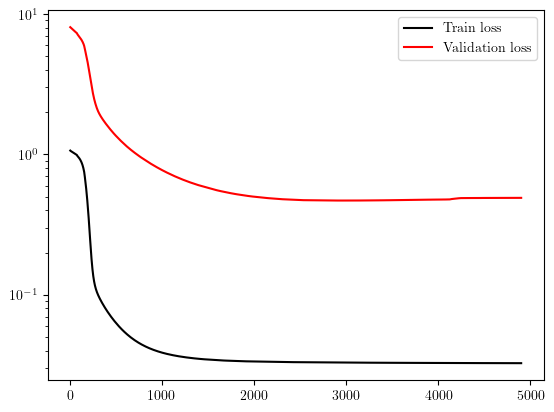

Best val loss: 0.46899158259232837


In [16]:
model_sentiment = train(train_dataloader=train_dataloader,
                           val_dataloader=val_dataloader,
                           sentiment=True,
                           lstm_hidden_size=2,
                           lstm_num_layers=1,
                           window_size=WINDOW_SIZE,
                           lr=1e-4,
                           epochs=5000,
                           use_scheduler=False,
                           scheduler_step=200,
                           scheduler_gamma=0.8,
                           mlp_hidden_size=16,
                           mlp_layers=1,
                           device=device)

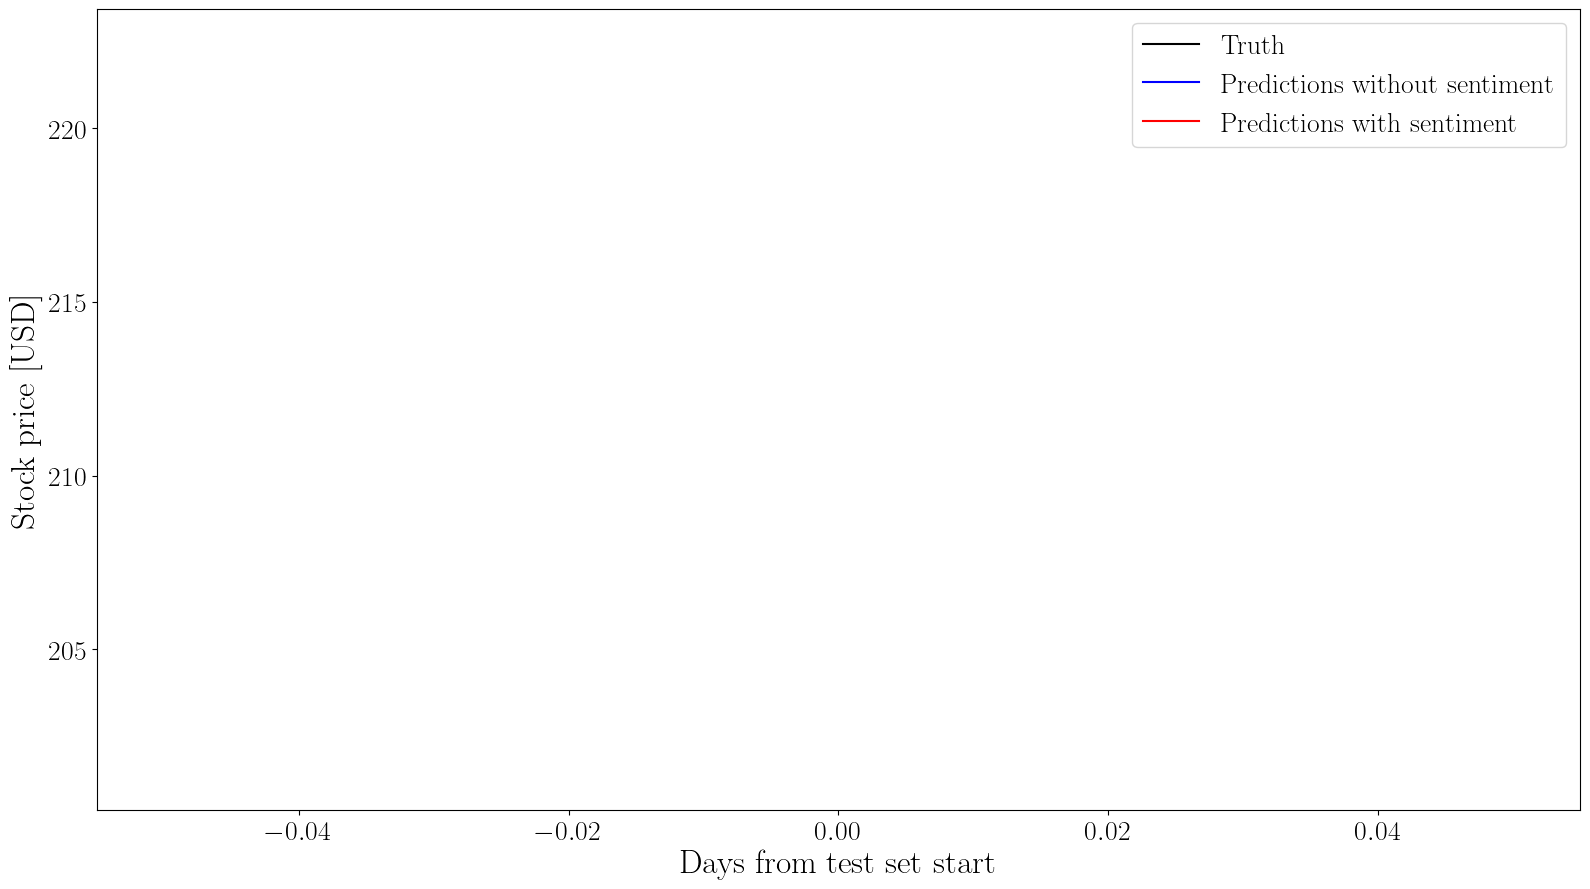

In [17]:
def unnormalize(y):
    return y * std + mean

with torch.no_grad():
    y_test_pred_no_sentiment = model_no_sentiment(X_test[:, :, 0:1])
    y_test_pred_sentiment = model_sentiment(X_test)

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(unnormalize(y_test), color="black", label="Truth")
ax.plot(unnormalize(y_test_pred_no_sentiment), color="blue", label="Predictions without sentiment")
ax.plot(unnormalize(y_test_pred_sentiment), color="red", label="Predictions with sentiment")

ax.set_xlabel("Days from test set start", fontsize=24)
ax.set_ylabel("Stock price [USD]", fontsize=24)

ax.tick_params(axis="both", labelsize=20)

plt.legend(fontsize=20)
plt.tight_layout()

plt.show()